# Coarse-graining of Brownian dynamics of toy model
## Predicting the first passage time using the constant probability flux (CPF) method

In [1]:
from sympy import *
from sympy.utilities.codegen import codegen
import numpy as np
from IPython.display import Markdown
import matplotlib.pyplot as plt
# import scipy.integrate as integrate

Consider a detailed dynamics, say MD, with the trajectory of some interesting species can reasonably be mapped to dynamics along a single reaction coordinate $x$.
It might then be desirable to coarse grain these simulations to a nonlinear, stochastic differential equation.
It is well established that such dynamics are equivalently described by a Fokker-Planck (or Smoluchowski) equation

\begin{equation}
\frac{\partial p}{\partial t} =
    \frac{\partial}{\partial x}\frac{1}{\zeta} \left[ \left(\frac{dF^\text{CG}}{d x}\right) p
    + k_\text{B}T \frac{\partial p}{\partial x}
    \right],
\end{equation}

where $p\equiv p(x;t|x_0;t_0)$ is the probability density of finding the species in the neighborhood of $x$ at time $t$, given that it had coordinate $x_0$ at some earlier time $t_0$.

The equivalent Ito-form stochastic differential equation is
\begin{equation}
dx = \left( \frac{d \zeta^{-1}}{d x} - \zeta^{-1} \frac{d F}{dx} \right) dt + \sqrt{2 \zeta^{-1}} d W_t
\end{equation}

We chose free energy of our toy system in a form:
\begin{equation}
\frac{F}{k_B T} = H_0 (1-x_0)^2 + \sum_{i=1}^{n-1} H_i (x_i - \mu_i)^2
\end{equation}
where $\mu_i=\frac{\sin A(x_0-C_i)}{B_i}$ 

In [2]:
#Number of dimensions
n=1

In [3]:
A = []
B = []
C = []
H = [4]

In [4]:
# A = [8, 8, 8, 8]
# B = [4, 4, 4, 4]
# C = [0, 0, 0, 0]

In [5]:
#Define variables
x = symbols('x0:%d'%n)

def floor(x,A,B,C):
    return sin(A*(x-C))/B

def wall(x,y,A,B,C):
    return (y - floor(x,A,B,C))**2

def free_energy(n, x):
    result = H[0]*(1-x[0])**2
    for i in range(1, n):
        result += H[i] * wall(x[0], x[i], A[i-1], B[i-1], C[i-1])
    return result

def free_energy_CG(x):
    return H[0]*(1-x[0])**2

def zeta_inv(n, x):
    return 0.5*(1+x[0]**2)**2 #friction

def tshift(n,x,i):
    return diff(zeta_inv(n,x), x[i])-zeta_inv(n, x)*diff(free_energy(n,x), x[i])

def wshift(n,x):
    return sqrt(2.0*zeta_inv(n, x))

In [6]:
Markdown("""
## Free energy of our {two}-dimensional toy model:
$F={one}$
""".format(one=latex(free_energy(n, x)),two=n))


## Free energy of our 1-dimensional toy model:
$F=4 \left(- x_{0} + 1\right)^{2}$


In [7]:
xx = MatrixSymbol('x', 1, n)
dx = MatrixSymbol('dx', 1, n)
dWt = MatrixSymbol('dWt', 1, n)
dt = symbols('dt')
subs_rule = list(zip(x,xx))
array = [(tshift(n,x,i) * dt + wshift(n,x) * dWt[i]).subs(subs_rule) for i in range(n)]
m = Matrix(1, n, array)
equation = Eq(dx, m)

In [8]:
equation

Eq(dx, Matrix([[dt*(-0.5*(8*x[0, 0] - 8)*(x[0, 0]**2 + 1)**2 + 2.0*(x[0, 0]**2 + 1)*x[0, 0]) + 1.0*sqrt((x[0, 0]**2 + 1)**2)*dWt[0, 0]]]))

### Calculate equilibrium distribution
\begin{equation}
p(x_i | x_0) = \frac{p(x_i, x_0)}{p(x_0)}
\end{equation}

In [9]:
p = symbols('p0:%d'%(n-1))
pp = MatrixSymbol('p', 1, n)
xx = MatrixSymbol('x', 1, n)
xa = symbols('xa')

subs_rule2 = list(zip(p,pp))
subs_rule2.insert(0,(x[0],xa))

#array2 = [solve(Eq((erf(p[i-1])+1)/2,simplify(integrate(exp(-wall(x[0], x[i], A[i-1], B[i-1], C[i-1])), (x[i],-oo,x[i]))/sqrt(pi))),x[i])[0].subs(subs_rule2) for i in range(1,n)]
array2 = [(floor(x[0],A[i],B[i],C[i]) + p[i]/sqrt(2*H[i+1])).subs(subs_rule2)  for i in range(0,n-1)]
array2.insert(0,xa)
m2 = Matrix(1, n, array2)
equation2 = Eq(xx, m2)

In [10]:
equation2

Eq(x, Matrix([[xa]]))

### Generate code for timestep and initialization

In [11]:
codegen(("shift",equation), "C", "shift", header=False, empty=False, to_files=True)
codegen(("init",equation2), "C", "init", header=False, empty=False, to_files=True)

In [12]:
! g++ FPT-gen.cpp shift.c init.c -o FPT-gen
! g++ CPF-gen.cpp shift.c init.c -o CPF-gen
#! g++ EQ-gen.cpp shift.c init.c -o EQ-gen

In [13]:
!./CPF-gen

### Processing CPF results

In [14]:
with open('cpf.dat') as f:
    lines = f.readlines()
    x0 = np.array([float(line.split()[0]) for line in lines])
    x0.sort()

In [15]:
x0.shape[0]

2000036

In [16]:
P = np.arange(0.0, 1.0, 1.0/x0.shape[0])

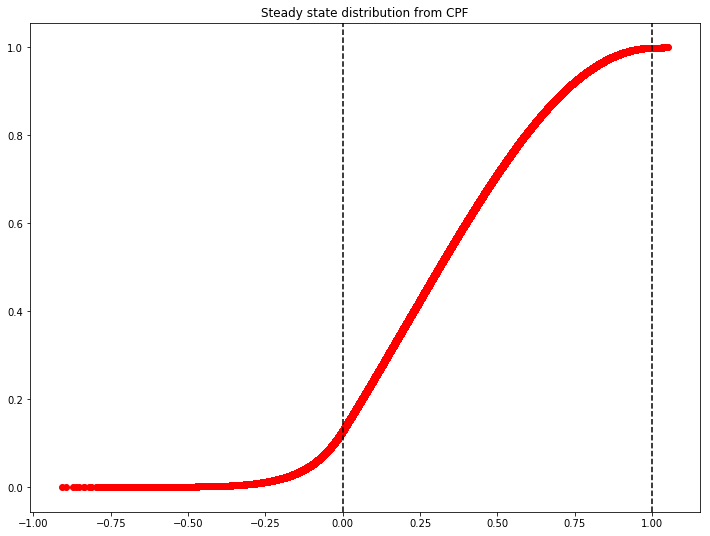

In [17]:
fig = plt.figure(figsize=(12, 9))

ax1 = fig.add_subplot(111)

ax1.set_title("Steady state distribution from CPF")
# ax1.set_xlabel(r'$t/\tau_c$')
# ax1.set_ylabel(r'$f_d(t)$')

ax1.scatter(x0,P, c='r', label=r'$f_d(t)$')
plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=1,  color='k', linestyle='--')
# ax1.plot(x,yline, c='b')
#plt.xlim(xmin=-1.1, xmax=-0.9)
#plt.ylim(ymin=0, ymax=0.05)
# leg = ax1.legend()
#ax1.set_xscale('log')
# ax1.set_yscale('log')

plt.show()

### Using [Kernel Density Estimation](http://scikit-learn.org/stable/modules/density.html) to find PDF in steady state

In [18]:
#Rule of thumb bandwith for kernel density estimstor
h = 1.06*np.std(x0)*np.size(x0)**(-0.2)
h

0.016404252185212288

In [19]:
from scipy.special import logsumexp

def myKernelDensity(x, h, xi):
    return np.sum(np.exp(-(x-xi)**2/(2*h**2)))/len(xi)
def myKernelDensityDerivative(x, h, xi):
    return np.sum(-(x-xi)/h**2*np.exp(-(x-xi)**2/(2*h**2)))/len(xi)

In [20]:
X_plot = np.linspace(0.0, 1.0, 1000)

In [24]:
mydens = [myKernelDensity(i, h, x0) for i in X_plot]

In [25]:
mydensder = [myKernelDensityDerivative(i, h, x0) for i in X_plot]

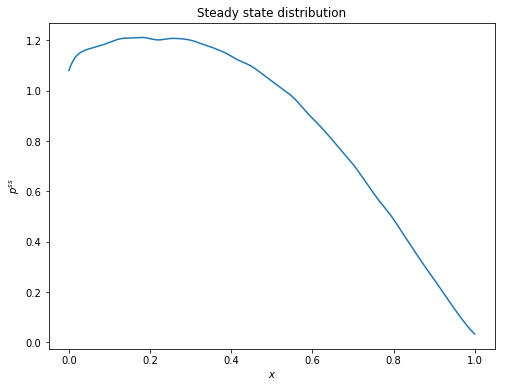

In [27]:
fig2 = plt.figure(figsize=(8, 6))

ax2 = fig2.add_subplot(111)

ax2.set_title("Steady state distribution")
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$p^{ss}$')

ax2.plot(X_plot, np.array(mydens)/np.sqrt(2*np.pi*h**2))

plt.show()

In [28]:
pCG = lambdify(x[0], exp(-free_energy_CG(x))/simplify(integrate(exp(-free_energy_CG(x)),(x[0],-oo,oo))), "sympy")

In [29]:
PCG = lambdify(x[0], simplify(integrate(exp(-free_energy_CG(x)),(x[0],-oo,x[0])))/simplify(integrate(exp(-free_energy_CG(x)),(x[0],-oo,oo))), "sympy")

In [30]:
with open('flux.dat') as f:
    lines = f.readlines()
J0 = float(lines[-1].split()[1])/float(lines[-1].split()[0])

In [31]:
xr=1

In [32]:
arr1 = np.array([(N(PCG(xr))-N(PCG(xT)))/N(pCG(xT))/J0 for xT in X_plot], dtype="float")

In [33]:
N(PCG(2))

0.997661132509476

##### Predict the first passage time assuming friction from detailed model

In [30]:
import scipy.integrate

In [0]:
fpt_cpf = [scipy.integrate.quad(lambda x: -(PCG(x)-PCG(1))/pCG(x), xT, 1)[0] for xT in X_plot]

##### Read detailed model predictions from file

In [66]:
! ./FPT-gen 0

In [347]:
with open('fpt_0.dat') as f:
    lines = f.readlines()
    fpt_bd_mean = np.zeros(len(lines[0].split()))
    fpt_bd_meansq = np.zeros(len(lines[0].split()))
    for line in lines:
        fpt_bd_mean += [float(i) for i in line.split()]
        fpt_bd_meansq += [float(i)**2 for i in line.split()]
    fpt_bd_mean /= len(lines)
    fpt_bd_meansq /= len(lines)

In [348]:
fpt_bd_mean[-1]*len(lines)/1e-4/20000000

0.05558334999999999

In [350]:
fpt_bd_meansq - fpt_bd_mean**2

array([4.96308368e-24, 5.49504000e-07, 1.11184000e-05, 2.30101440e-05,
       2.02749600e-04, 2.68392736e-04, 1.21135126e-03, 2.83852330e-03,
       5.79683760e-03, 7.52625680e-03, 3.16192140e-02, 3.34131083e-02,
       5.00002190e-02, 2.29067148e-01, 3.64604448e-01, 4.11074372e-01,
       8.18602805e-01, 4.61929840e+00, 4.51355149e+00, 8.98651373e+00,
       1.06705057e+01])

In [351]:
fpt_bd_stderr = np.sqrt(abs(fpt_bd_meansq - fpt_bd_mean**2))/np.sqrt(len(lines))

In [352]:
np.divide(fpt_bd_stderr, fpt_bd_mean)

array([4.45559589e-09, 1.30507988e-01, 1.55814322e-01, 1.29926571e-01,
       1.90871539e-01, 1.57465362e-01, 1.72111917e-01, 1.62313532e-01,
       1.33926062e-01, 1.30437531e-01, 1.62097690e-01, 1.38275964e-01,
       1.34919381e-01, 1.86070134e-01, 1.71593798e-01, 1.41731507e-01,
       1.64745064e-01, 2.29172254e-01, 1.90266170e-01, 1.57231378e-01,
       1.46922325e-01])

##### Compare results

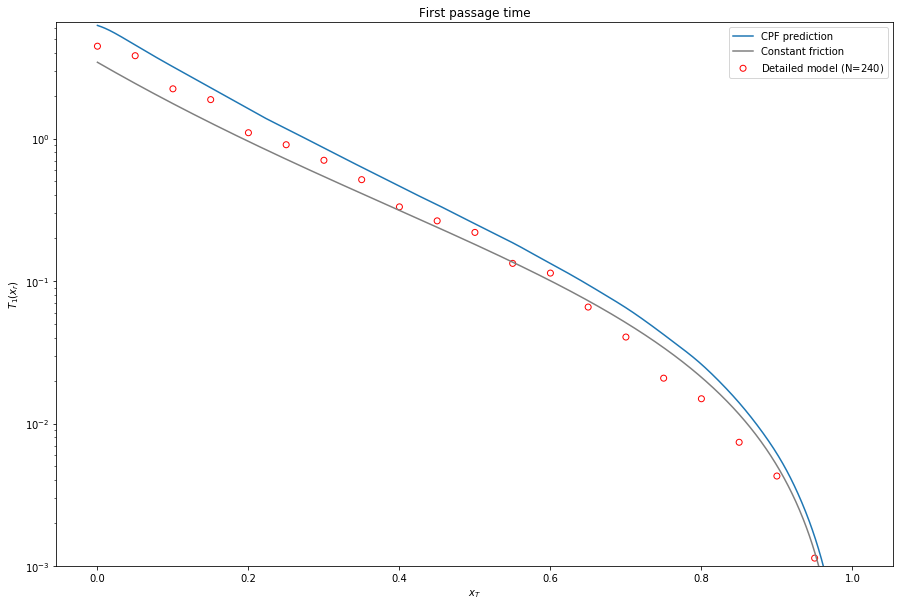

In [353]:
fig4 = plt.figure(figsize=(15, 10))

ax4 = fig4.add_subplot(111)

ax4.set_title("First passage time")
ax4.set_xlabel(r'$x_T$')
ax4.set_ylabel(r'$T_1(x_r)$')

ax4.plot(X_plot, np.array(mydens)/np.sqrt(2*np.pi*h**2) * arr1, label='CPF prediction')
ax4.plot(X_plot, fpt_cpf, c='gray', label='Constant friction')
ax4.scatter(np.arange(1.0,-0.05,-0.05), fpt_bd_mean, facecolors='none', edgecolors='r', label='Detailed model (N=$240$)')
#ax4.errorbar(np.arange(1.0,-1.05,-0.05), fpt_bd_mean, yerr=fpt_bd_stderr, c='r', fmt='o')
#plt.xlim(xmin=-1, xmax=1)
plt.ylim(ymin=1e-3)
leg = ax4.legend()
ax4.set_yscale('log')

plt.show()

In [48]:
with open('fptlist_5D_CPF.dat', 'w') as f:
    for i in list(zip(X_plot[:, 0], np.exp(log_dens) * arr1)):
        f.write("%s\t" % i[0])
        f.write("%s\n" % i[1])

In [49]:
with open('fptlist_5D_CPF_const_friction.dat', 'w') as f:
    for i in list(zip(X_plot[:, 0], fpt_cpf)):
        f.write("%s\t" % i[0])
        f.write("%s\n" % i[1])

In [51]:
with open('fptlist_5D_BD.dat', 'w') as f:
    for i in list(zip(np.arange(1.00,-1.00,-0.05), fpt_bd_mean, fpt_bd_stderr)):
        f.write("%s\t" % i[0])
        f.write("%s\t" % i[1])
        f.write("%s\n" % i[2])

# Friction

## 1. Friction from KDE of $p^{ss}$

In [34]:
dFdx = lambdify(x[0],diff(free_energy_CG(x)))

In [35]:
actual_friction = lambdify(x[0],zeta_inv(n, x))

In [36]:
dFdX_arr = [dFdx(i) for i in X_plot]

In [37]:
friction = -(np.multiply(mydens,dFdX_arr)+mydensder)/J0/np.sqrt(2*np.pi*h**2)

In [38]:
act_f = [1/actual_friction(i) for i in X_plot]

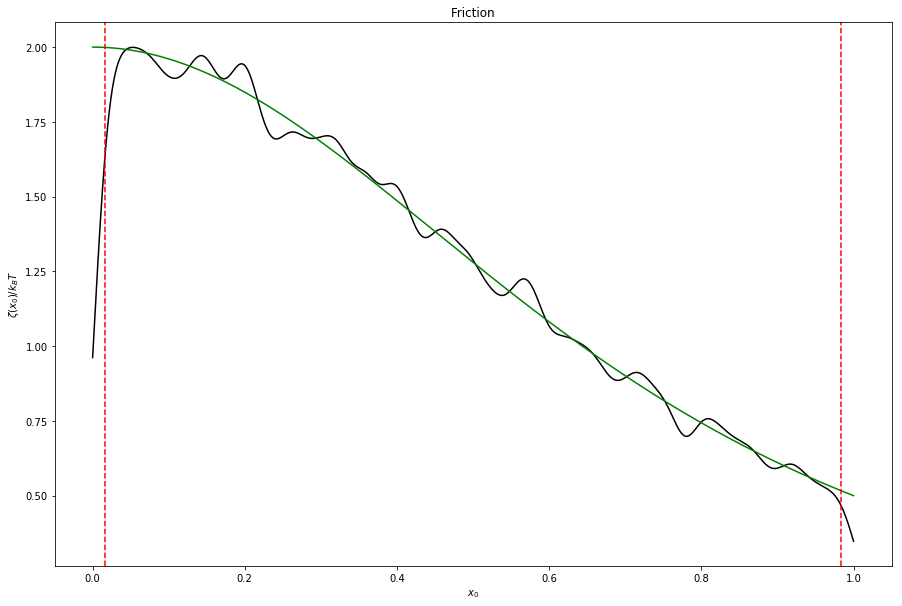

In [39]:
fig5 = plt.figure(figsize=(15, 10))

ax5 = fig5.add_subplot(111)

ax5.set_title("Friction")
ax5.set_xlabel(r'$x_0$')
ax5.set_ylabel(r'$\zeta(x_0)/k_B T$')

ax5.plot(X_plot, friction, c='k')
ax5.plot(X_plot, act_f, c='g', label='Actual friction')
plt.axvline(x=h, color='r', linestyle='--')
plt.axvline(x=xr-h, color='r', linestyle='--')

plt.show()

In [222]:
with open('zeta_1D_kde.dat', 'w') as f:
    for i in list(zip(X_plot[:, 0], friction)):
        f.write("%s\t" % i[0])
        f.write("%s\n" % i[1])

## 2. Fitting friction with a sum of Chebyshev polynomials

\begin{equation}
\mathbb{P}^\text{ss}(x) =
\int_{x_s}^{x}
 \mathbb{P}^\text{eq}(x')
 \frac{\tilde{\zeta}(x')}{p^\text{eq}(x')} dx' +
 \mathbb{P}^\text{eq}(x)
 \int_{x}^{x_a}
 \frac{\tilde{\zeta}(x')}{p^\text{eq}(x')} dx'
\end{equation}
where 
\begin{equation}
\tilde{\zeta}(x) := \frac{J_0 \zeta(x)}{k_\text{B}T}
\end{equation}

We fit friction with the sum of Chebychev's polynomials, so that
\begin{equation}
\tilde{\zeta}(x) = \sum_i c_i T_i(x)
\end{equation}

\begin{equation}
\mathbb{P}^\text{ss}(x) = \sum_i c_i \left( \int_{x_s}^{x}
 \mathbb{P}^\text{eq}(x')
 \frac{T_i(x')}{p^\text{eq}(x')} dx' +
 \mathbb{P}^\text{eq}(x)
 \int_{x}^{x_a}
 \frac{T_i(x')}{p^\text{eq}(x')} dx' \right) = 
\sum_i c_i I_i(x)
\end{equation}

We define the set of reference points $\{ x_j \}$ and solve matrix equation
\begin{equation}
c_i I_i(x_j) = \mathbb{P}^{ss}(x_j)
\end{equation}
to find the set of weights $\{c_i\}$

In [250]:
def integral1(n, lower, upper):
    return integrate.quad(lambda x: PCG(x)*chebyshevt_poly(n,x)/pCG(x), lower, upper)[0]

def integral2(n, lower, upper):
    return integrate.quad(lambda x: chebyshevt_poly(n,x)/pCG(x), lower, upper)[0]

def Pss_cheb(x, n, L0, La):
    return integral1(n,L0,x)+N(PCG(x))*integral2(n,x,La)

In [389]:
nmodes=7 #number of Chebyshev polynomials (starting from 0-th)
npoints=500 #reference points in domain
III = [[Pss_cheb(j/npoints, i, 0, 1) for i in range(nmodes)] for j in range(npoints)]
rhs = [PSS_func(j/npoints) for j in range(npoints)]
fit = np.linalg.lstsq(III, rhs, rcond=-1)[0]
fit

array([-10.39363304,  25.2079183 , -17.19444879,   4.21159158,
         1.96148294,  -1.72204359,   0.63927963])

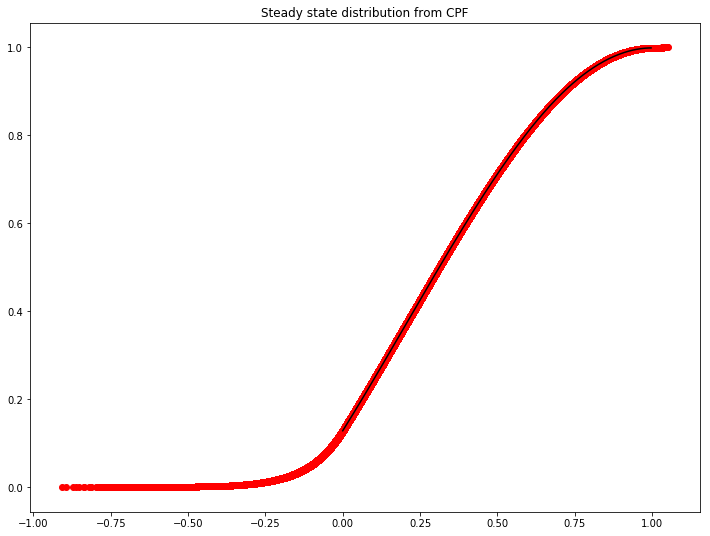

In [386]:
fig = plt.figure(figsize=(12, 9))

ax1 = fig.add_subplot(111)

ax1.set_title("Steady state distribution from CPF")
# ax1.set_xlabel(r'$t/\tau_c$')
# ax1.set_ylabel(r'$f_d(t)$')

ax1.scatter(x0,P, c='r', label=r'$f_d(t)$')
ax1.plot(np.arange(npoints)/npoints, [sum([fit[i]*Pss_cheb(j/npoints, i, 0, 1) for i in range(nmodes)]) for j in range(npoints)], c='k', label='Chebychev approximation')


#plt.xlim(xmin=-1.1, xmax=-0.9)
#plt.ylim(ymin=0, ymax=0.05)
# leg = ax1.legend()
#ax1.set_xscale('log')
# ax1.set_yscale('log')

plt.show()

In [392]:
cheb_friction = [sum([fit[i]*chebyshevt_poly(i,j)/J0 for i in range(nmodes)]) for j in X_plot]

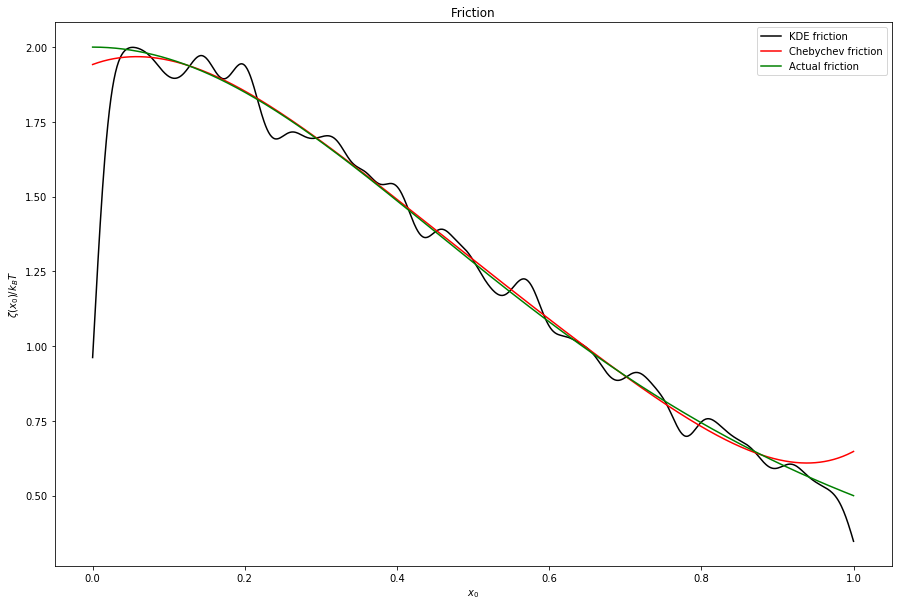

In [394]:
fig5 = plt.figure(figsize=(15, 10))

ax5 = fig5.add_subplot(111)

ax5.set_title("Friction")
ax5.set_xlabel(r'$x_0$')
ax5.set_ylabel(r'$\zeta(x_0)/k_B T$')

ax5.plot(X_plot, friction, c='k', label='KDE friction')
ax5.plot(X_plot, cheb_friction, c='r', label='Chebychev friction')
ax5.plot(X_plot, act_f, c='g', label='Actual friction')
leg = ax5.legend()

plt.show()